#  Building a Spam Filter with Naive Bayes

## Our Goal:
Build a simple **spam detector** for text messages (SMS) using the Naive Bayes algorithm.

**How?**

- We’ll train the computer to tell the difference between spam (junk messages) and normal messages.

- We’ll test it to see how well it works.

**Why Naive Bayes?**

- It’s great for text (like messages).

- It’s simple but effective.




## First task :

**To classify messages as spam or non-spam, the computer:**
1. Learns how humans classify messages.
2. Uses that human knowledge to estimate probabilities for new messages — probabilities for spam and non-spam.
3. Classifies a new message based on these probability values — if the probability for spam is greater, then it classifies the message as spam. Otherwise, it classifies it as non-spam (if the two probability values are equal, then we may need a human to classify the message).


## The Dataset & The Authors :
To  **"teach" the computer**, we'll use the multinomial Naive Bayes algorithm along with a dataset of 5,572 SMS messages that are already classified by humans.

The dataset was put together by Tiago A. Almeida and José María Gómez Hidalgo, and it can be downloaded from the The [UCI Machine Learning Repository.](https://archive.ics.uci.edu/dataset/228/sms+spam+collection)



In [64]:
import pandas as pd
import re

In [65]:
sms_collection = pd.read_csv('SMSSpamCollection',sep='\t', header=None, names=['Label', 'SMS'])
sms_collection.shape

(5572, 2)

In [66]:
sms_collection.head()

,Label,SMS
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


The "ham" means non-spam

Lets's finding the percentage of spams and hams :


In [67]:
sms_collection['Label'].value_counts()

Label
ham     4825
spam     747
Name: count, dtype: int64

In [68]:
sms_collection['Label'].value_counts(normalize=True) * 100

Label
ham     86.593683
spam    13.406317
Name: proportion, dtype: float64

**Percentage of labels :**
About 87% of the messages are ham, and the remaining 13% are spam

# Training and Test Set
We're first going to split our dataset into two categories:

1. A **training set**, which we'll use to "train" the computer how to classify messages.
2. A **test set**, which we'll use to test how good the spam filter is with classifying new messages.

We're going to keep 80% of our dataset for training, and 20% for testing (we want to train the algorithm on as much data as possible, but we also want to have enough test data). The dataset has 5,572 messages, which means that:

- The training set will have 4,458 messages (about 80% of the dataset).
- The test set will have 1,114 messages (about 20% of the dataset).

In [69]:
randomized_data = sms_collection.sample(frac=1, random_state=1)
#Use the frac=1 parameter to randomize the entire dataset.
#Use the random_state=1 parameter to make sure your results are reproducible.

#specifying a length for 80% of the data:
len_of_data = round(len(randomized_data)* 0.8)

#The training data :
training_data = randomized_data[:len_of_data].reset_index(drop=True)

#The test data :
test_data = randomized_data[len_of_data:].reset_index(drop=True)

In [70]:
print(f" The taraining data shape is : {training_data.shape}")
print(f" The test data shape is : {test_data.shape}")

 The taraining data shape is : (4458, 2)
 The test data shape is : (1114, 2)


Finding the percentage of spam and ham in both the training and the test set :

In [71]:
training_data['Label'].value_counts(normalize=True) * 100

Label
ham     86.54105
spam    13.45895
Name: proportion, dtype: float64

In [72]:
training_data.head()

,Label,SMS
0,ham,"Yep, by the pretty sculpture"
1,ham,"Yes, princess. Are you going to make me moan?"
2,ham,Welp apparently he retired
3,ham,Havent.
4,ham,I forgot 2 ask ü all smth.. There's a card on ...


In [73]:
test_data['Label'].value_counts(normalize=True) * 100

Label
ham     86.804309
spam    13.195691
Name: proportion, dtype: float64

In [74]:
test_data.head()

,Label,SMS
0,ham,Later i guess. I needa do mcat study too.
1,ham,But i haf enuff space got like 4 mb...
2,spam,Had your mobile 10 mths? Update to latest Oran...
3,ham,All sounds good. Fingers . Makes it difficult ...
4,ham,"All done, all handed in. Don't know if mega sh..."


It looks good. we have  a very close proportion for ham and spam in both datasets

# Cleaning the Data :
First, we'll clean the data to make it easier to calculate the probabilities for the algorithm.

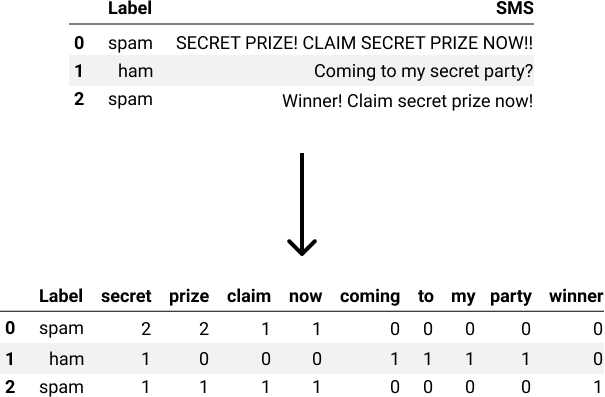

Let's begin the data cleaning process by removing the punctuation and bringing all the words to lower case.

In [75]:
training_data.head()

,Label,SMS
0,ham,"Yep, by the pretty sculpture"
1,ham,"Yes, princess. Are you going to make me moan?"
2,ham,Welp apparently he retired
3,ham,Havent.
4,ham,I forgot 2 ask ü all smth.. There's a card on ...


In [76]:
#using re.sub function to remove the punctuation but keeps spaces
training_data['SMS'] = training_data['SMS'].apply(lambda x: re.sub(r'[^\w\s]|_', ' ', x))

training_data['SMS'] = training_data['SMS'].str.lower()

training_data.head()

,Label,SMS
0,ham,yep by the pretty sculpture
1,ham,yes princess are you going to make me moan
2,ham,welp apparently he retired
3,ham,havent
4,ham,i forgot 2 ask ü all smth there s a card on ...


# Creating the Vocabulary
Create a vocabulary for the messages in the training set. The vocabulary should be a Python list containing all the unique words across all messages, where each word is represented as a string.

In [77]:
# transforming each message from the SMS column into a list
training_data['SMS'] = training_data['SMS'].str.split()

In [78]:
vocabulary = []

for strings in training_data['SMS'] :
    for vocab in strings :
        vocabulary.append(vocab)
#turn the vocabulary list to set to remove the dublicates and turn it to a list again:
vocabulary = list(set(vocabulary))


In [79]:
print(len(vocabulary))

7780


Now there is 7.780 seperated words in vocabulary list

# The Final Training set :
Now we're going to use the vocabulary to make the data transformation we need, first we make a dictionary and then turn it to a dataframe

In [80]:
word_counts_per_sms = {unique_word : [0] * len(training_data['SMS']) for unique_word in vocabulary}

for index ,sms in enumerate(training_data['SMS']) :
    for word in sms :
        word_counts_per_sms[word][index] +=1
        
    

In [81]:
word_counter_pd = pd.DataFrame(word_counts_per_sms)
word_counter_pd.head()

,boooo,resort,dresser,lotsof,vijay,fingers,audrie,restaurant,shanghai,500,...,forced,gotbabes,09050002311,1stone,08714712394,eighth,prayrs,tiwary,registered,messaging
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [82]:
cleaned_training_data = pd.concat([training_data, word_counter_pd], axis=1)
cleaned_training_data.head()

,Label,SMS,boooo,resort,dresser,lotsof,vijay,fingers,audrie,restaurant,...,forced,gotbabes,09050002311,1stone,08714712394,eighth,prayrs,tiwary,registered,messaging
0,ham,"[yep, by, the, pretty, sculpture]",0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,ham,"[yes, princess, are, you, going, to, make, me,...",0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,ham,"[welp, apparently, he, retired]",0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,ham,[havent],0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,ham,"[i, forgot, 2, ask, ü, all, smth, there, s, a,...",0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# Calculating Constants First
These are the equations we need for calculation :

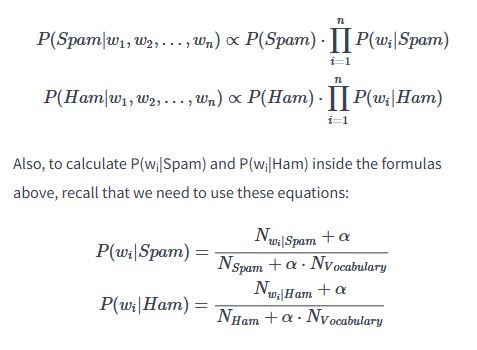

Some of the terms in the four equations above will have the same value for every new message. As a start, let's first calculate:

**P(Spam) and P(Ham)**
NSpam, NHam, NVocabulary
Recall that:

- **NSpam** is equal to the number of words in all the spam messages — it's not equal to the number of spam messages, and it's not equal to the total number of unique words in spam messages.
- **NHam** is equal to the number of words in all the non-spam messages — it's not equal to the number of non-spam messages, and it's not equal to the total number of unique words in non-spam messages.

We'll also use Laplace smoothing and set α=1

**all these bellow terms will have constant values in our equations for every new message** *(regardless of the message or each individual word in the message).*

In [83]:
#Calculate P(Spam) and P(Ham)
spam_messages = cleaned_training_data[cleaned_training_data['Label'] == 'spam']
ham_messages = cleaned_training_data[cleaned_training_data['Label'] == 'ham']

p_spam = len(spam_messages) / len(cleaned_training_data)
p_ham = len(ham_messages) / len(cleaned_training_data)

#N spam
n_words_in_spam = spam_messages['SMS'].apply(len)
n_spam = n_words_in_spam.sum()

#N ham
n_words_in_ham = ham_messages['SMS'].apply(len)
n_ham = n_words_in_ham.sum()

#N vocabulary
n_vocabulary = len(vocabulary)

alpha = 1

# Calculating Parameters
now we are going to calculate P(wi|Spam) and P(wi|Ham) which will be vary depending on the individual words

\begin{equation}
P(w_i|Spam) = \frac{N_{w_i|Spam} + \alpha}{N_{Spam} + \alpha \cdot N_{Vocabulary}}
\end{equation}

\begin{equation}
P(w_i|Ham) = \frac{N_{w_i|Ham} + \alpha}{N_{Ham} + \alpha \cdot N_{Vocabulary}}
\end{equation}

In [84]:
#Initialize two dictionaries for spam and ham, where each key-value pair is a unique word (from our vocabulary), and the value is 0
spam_parameters = {unique_word:0 for unique_word in vocabulary}
ham_parameters = {unique_word:0 for unique_word in vocabulary}

#we have already isolated the spam and the ham messages in the previous cell, into two different DataFrames- spam_messages & ham_messages
#for each word, calculate P(wi|Spam) and P(wi|Ham)

for word in vocabulary :
    N_word_given_by_spam = spam_messages[word].sum()
    P_word_given_by_spam = (N_word_given_by_spam + alpha) / (n_spam+alpha * (n_vocabulary))
    spam_parameters[word] = P_word_given_by_spam

    N_word_given_by_ham = ham_messages[word].sum()
    P_word_given_by_ham = (N_word_given_by_ham+alpha) / (n_ham+alpha * (n_vocabulary))
    ham_parameters[word] = P_word_given_by_ham



# Classifying A New Message
Now that we've calculated all the constants and parameters we need, we can start creating the spam filter. The spam filter can be understood as a function that:

- Takes in as input a new message (w1, w2, ..., wn)
- Calculates P(Spam|w1, w2, ..., wn) and P(Ham|w1, w2, ..., wn)
- Compares the values of P(Spam|w1, w2, ..., wn) and P(Ham|w1, w2, ..., wn), and:
  - If P(Ham|w1, w2, ..., wn) > P(Spam|w1, w2, ..., wn), then the message is classified as ham.
  - If P(Ham|w1, w2, ..., wn) < P(Spam|w1, w2, ..., wn), then the message is classified as spam.
  - If P(Ham|w1, w2, ..., wn) = P(Spam|w1, w2, ..., wn), then the algorithm may request human help

In [85]:
def classify(messages) :
    #cleaning the data messages:
    messages = re.sub(r'[^\w\s]|_', ' ', messages)
    messages = messages.lower()
    messages = messages.split()

    p_spam_given_message = p_spam
    p_ham_given_message = p_ham

    for word in messages :
        if word in spam_parameters :
            p_spam_given_message *= spam_parameters[word]

        if word in ham_parameters :
            p_ham_given_message *= ham_parameters[word]

    print('p(spam|message): ', p_spam_given_message)
    print('p(ham|message): ', p_ham_given_message)

    if p_ham_given_message > p_spam_given_message:
        print('Label : ham')
    if p_spam_given_message > p_ham_given_message:
        print('Label : spam')
    if p_spam_given_message == p_ham_given_message :
        print('Equal probabilities, needs to classify by a human!')



    

In [86]:
test_message_1 = 'WINNER!! This is the secret code to unlock the money: C3421.'
test_func_1 = classify(test_message_1)


p(spam|message):  1.3481290211300841e-25
p(ham|message):  1.938682546922174e-27
Label : spam


In [87]:
test_message_2 = "Sounds good, Tom, then see u there"
test_func_2 = classify(test_message_2)

p(spam|message):  2.4372375665888117e-25
p(ham|message):  3.690310607691019e-21
Label : ham


# Measuring the Spam Filter's Accuracy
To testing the function, we start by changing the print statement with return. and also adding a new column to the test_data to compare the prediction of function with the label column

In [88]:
#changin the print statement:
def classify_test_data(messages) :
    #cleaning the data messages:
    messages = re.sub(r'[^\w\s]|_', ' ', messages)
    messages = messages.lower()
    messages = messages.split()

    p_spam_given_message = p_spam
    p_ham_given_message = p_ham

    for word in messages :
        if word in spam_parameters :
            p_spam_given_message *= spam_parameters[word]

        if word in ham_parameters :
            p_ham_given_message *= ham_parameters[word]

    print('p(spam|message): ', p_spam_given_message)
    print('p(ham|message): ', p_ham_given_message)

    if p_ham_given_message > p_spam_given_message:
        return 'ham'
    if p_spam_given_message > p_ham_given_message:
        return 'spam'
    if p_spam_given_message == p_ham_given_message :
        return 'needs to classify by a human!'
   

In [93]:
#creat a new column :
test_data['prediction'] = test_data['SMS'].apply(classify_test_data)

In [90]:
test_data.head()

,Label,SMS,prediction
0,ham,Later i guess. I needa do mcat study too.,ham
1,ham,But i haf enuff space got like 4 mb...,ham
2,spam,Had your mobile 10 mths? Update to latest Oran...,spam
3,ham,All sounds good. Fingers . Makes it difficult ...,ham
4,ham,"All done, all handed in. Don't know if mega sh...",ham


Now we can compare the predicted values with the actual values to measure how good our spam filter is with classifying new messages. To make the measurement, we'll use accuracy as a metric:

\begin{equation}
\text{Accuracy} = \frac{\text{number of correctly classified messages}}{\text{total number of classified messages}}
\end{equation}

In [91]:
correct = 0
total = test_data.shape[0]

for row in test_data.iterrows():
    row=row[1]
    if row['Label'] == row['prediction']:
        correct +=1


print('Correct:', correct)
print('Incorrect:', total - correct)
print('Accuracy:', correct/total)

Correct: 1100
Incorrect: 14
Accuracy: 0.9874326750448833


The model achieved an accuracy of 98.74%, which is excellent. When tested on 1,114 previously unseen messages, it correctly classified 1,100 of them

# Isolating Incorrectly Classified Messages
lets look closer to incorrect part :


In [92]:
incorrect_classified = test_data[test_data['Label'] != test_data['prediction']]
print(incorrect_classified['SMS'])

114    Not heard from U4 a while. Call me now am here...
135    More people are dogging in your area now. Call...
152                    Unlimited texts. Limited minutes.
159                                         26th OF JULY
284                               Nokia phone is lovly..
293    A Boy loved a gal. He propsd bt she didnt mind...
302                     No calls..messages..missed calls
319    We have sent JD for Customer Service cum Accou...
504    Oh my god! I've found your number again! I'm s...
546    Hi babe its Chloe, how r u? I was smashed on s...
741    0A$NETWORKS allow companies to bill for SMS, s...
876             RCT' THNQ Adrian for U text. Rgds Vatian
885                                        2/2 146tf150p
953    Hello. We need some posh birds and chaps to us...
Name: SMS, dtype: object


Here are some possible reasons why the algorithm may have misclassified the messages:

- **Insufficient training data:** If the training data does not contain enough examples of a particular type of message, the algorithm may not be able to learn the patterns and features that distinguish that type of message.
- **Overfitting or underfitting:** If the algorithm is overfitting or underfitting the training data, it may not generalize well to new, unseen data, leading to incorrect classifications.
- **Noise or outliers in the data:** If there is noise or outliers in the data, the algorithm may be misled by these irregularities and make incorrect classifications.
- **Limited feature set:** If the feature set used by the algorithm is limited, it may not be able to capture the nuances and complexities of the data, leading to incorrect classifications.
- **Class imbalance:** If one class has a significantly larger number of instances than the other, the algorithm may be biased towards the majority class and misclassify instances of the minority class.
